In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
from SimpleTorch import Tensor, no_grad
from SimpleTorch.data_tools import Dataset, DataLoader
from SimpleTorch.operators import ReLU, MSELoss
from SimpleTorch.modules import Module, Linear, Sequential
from SimpleTorch.optim import SGD


---
## 准备数据

In [2]:
sample_num = 10000
a, b, c, d = 1, 2, 3, 4
x = np.random.rand(sample_num) * 2 * math.pi - math.pi
y = a * np.cos(b * x) + c * np.sin(d * x)

In [3]:
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

In [4]:
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(10000, 1) (10000, 1)
float64 float64


---
### 特征工程

In [5]:
x_square = x * x
x_sin = np.sin(x)
x_cos = np.cos(x)
print(x_square.shape, x_sin.shape, x_cos.shape)

(10000, 1) (10000, 1) (10000, 1)


In [6]:
x_feature = np.concatenate((x, x_square, x_sin, x_cos), axis=1)
print(x_feature.shape)

(10000, 4)


In [7]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [8]:
ratio = 0.8
train_sample_num = int(sample_num * ratio)
train_dataset = MyDataset(x_feature[0:train_sample_num], y[0:train_sample_num])
test_dataset = MyDataset(x_feature[train_sample_num:], y[train_sample_num:])

In [9]:
print(len(train_dataset), len(test_dataset))

8000 2000


---
### 可视化数据看一眼

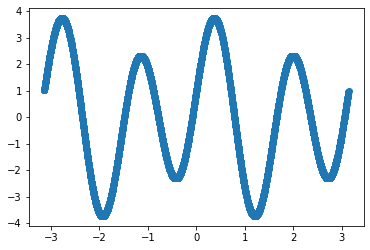

In [10]:
plt.scatter(x[0:train_sample_num], y[0:train_sample_num])

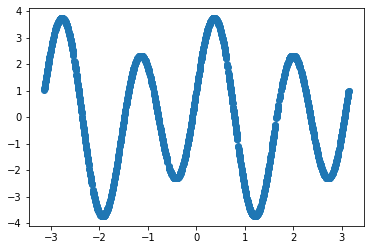

In [11]:
plt.scatter(x[train_sample_num:], y[train_sample_num:])

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50)

In [13]:
temp = next(iter(train_dataloader))
print(type(temp))
print(len(temp))
print(type(temp[0]), type(temp[1]))
print(temp[0].shape, temp[0].dtype)
print(temp[1].shape, temp[1].dtype)

<class 'list'>
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(50, 4) float64
(50, 1) float64


---
## 模型部分

In [14]:
class MLP(Module):
    def __init__(self, layer_num, units):
        super(MLP, self).__init__()
        
        layers = []
        for i in range(layer_num):
            if i == 0:
                layers += [Linear(4, units[i]),
                            ReLU()]
            else:
                layers += [Linear(units[i - 1], units[i]),
                            ReLU()]
        layers += [Linear(units[-1], 1)]
        
        self.layers = Sequential(*layers)
    
    def forward(self, x):
        y = self.layers(x)

        return y

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer, total_epoch, cur_epoch):
    pbar = tqdm(dataloader, desc=f'Epoch {cur_epoch}/{total_epoch}', unit='batch')

    for i, (x, y) in enumerate(pbar):
        x = Tensor(x)
        y = Tensor(y)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        if i % 5 == 0:
            pbar.set_postfix_str(f'loss={loss.data.item():.4f}')

In [16]:
def test_loop(dataloader, model, loss_fn):
    steps = len(dataloader)
    loss = 0.0
    
    with no_grad():
        for x, y in dataloader:
            x = Tensor(x)
            y = Tensor(y)

            y_pred = model(x)
            loss += loss_fn(y_pred, y).data.item()
    
    loss = loss / steps

    print(f'test_loss={loss:.4f}')

---
## 开始训练

In [17]:
mlp = MLP(2, [16, 16])
print(mlp)

In [18]:
for name, param in mlp.parameters:
    print(name, param.data.shape, param.data.dtype)

layers_0_weight (16, 4) float64
layers_0_bias (16,) float64
layers_2_weight (16, 16) float64
layers_2_bias (16,) float64
layers_4_weight (1, 16) float64
layers_4_bias (1,) float64


In [19]:
loss_fn = MSELoss()
optimizer = SGD(mlp.parameters, lr=0.01)

In [20]:
epochs = 100
for i in range(epochs):
    train_loop(train_dataloader, mlp, loss_fn, optimizer, epochs, i)
    test_loop(test_dataloader, mlp, loss_fn)

Epoch 0/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=4.1110


Epoch 1/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=3.2686


Epoch 2/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=3.4953


Epoch 3/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=2.4869


Epoch 4/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=1.0302


Epoch 5/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.9259


Epoch 6/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.7072


Epoch 7/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=1.1589


Epoch 8/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.4077


Epoch 9/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.3033


Epoch 10/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.2847


Epoch 11/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.1987


Epoch 12/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.2956


Epoch 13/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.1206


Epoch 14/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.1067


Epoch 15/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.2020


Epoch 16/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0599


Epoch 17/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0896


Epoch 18/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0579


Epoch 19/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0493


Epoch 20/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.1262


Epoch 21/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0290


Epoch 22/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0450


Epoch 23/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0178


Epoch 24/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0410


Epoch 25/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0182


Epoch 26/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0424


Epoch 27/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0148


Epoch 28/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0125


Epoch 29/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0123


Epoch 30/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0093


Epoch 31/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0084


Epoch 32/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0077


Epoch 33/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0648


Epoch 34/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0092


Epoch 35/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0076


Epoch 36/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0073


Epoch 37/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0063


Epoch 38/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0307


Epoch 39/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0074


Epoch 40/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0095


Epoch 41/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0154


Epoch 42/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0055


Epoch 43/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0050


Epoch 44/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0098


Epoch 45/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0048


Epoch 46/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0095


Epoch 47/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0058


Epoch 48/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0110


Epoch 49/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0060


Epoch 50/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0042


Epoch 51/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0051


Epoch 52/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0054


Epoch 53/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0038


Epoch 54/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0041


Epoch 55/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0050


Epoch 56/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0053


Epoch 57/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0048


Epoch 58/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0037


Epoch 59/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0037


Epoch 60/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0045


Epoch 61/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0041


Epoch 62/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0042


Epoch 63/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0053


Epoch 64/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0050


Epoch 65/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0045


Epoch 66/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0039


Epoch 67/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0085


Epoch 68/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0042


Epoch 69/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0040


Epoch 70/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0322


Epoch 71/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0035


Epoch 72/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0039


Epoch 73/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0156


Epoch 74/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0038


Epoch 75/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0166


Epoch 76/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0040


Epoch 77/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0051


Epoch 78/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0033


Epoch 79/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0040


Epoch 80/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0126


Epoch 81/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0100


Epoch 82/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0033


Epoch 83/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0034


Epoch 84/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0031


Epoch 85/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0067


Epoch 86/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0037


Epoch 87/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0031


Epoch 88/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0033


Epoch 89/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0037


Epoch 90/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0028


Epoch 91/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0035


Epoch 92/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0039


Epoch 93/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0034


Epoch 94/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0033


Epoch 95/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0038


Epoch 96/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0160


Epoch 97/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0028


Epoch 98/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0028


Epoch 99/100:   0%|          | 0/160 [00:00<?, ?batch/s]

test_loss=0.0029


---
## 看一下模型拟合的效果

In [21]:
with no_grad():
    temp = Tensor(x_feature[train_sample_num:])
    y_pred = mlp(temp)
    print(y_pred.data.shape)

(2000, 1)


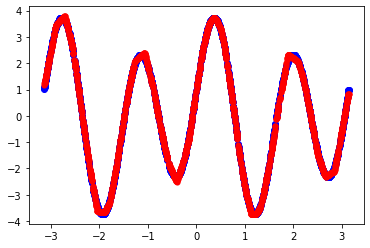

In [22]:
plt.scatter(x[train_sample_num:], y[train_sample_num:], c='b')
plt.scatter(x[train_sample_num:], y_pred.data, c='r', linewidths=0.1)